In [24]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.6MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 204kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 7.62MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



We pass the `Dataset` as an argument to `DataLoader`. This wraps an

*   List item
*   List item


iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [17]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [9]:
epochs = 10 #increase epochs 5 -> 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.155299  [   64/60000]
loss: 1.164929  [ 6464/60000]
loss: 0.979922  [12864/60000]
loss: 1.120829  [19264/60000]
loss: 0.983572  [25664/60000]
loss: 1.021125  [32064/60000]
loss: 1.054129  [38464/60000]
loss: 0.999708  [44864/60000]
loss: 1.038038  [51264/60000]
loss: 0.966823  [57664/60000]
Test Error: 
 Accuracy: 66.0%, Avg loss: 0.982746 

Epoch 2
-------------------------------
loss: 1.038210  [   64/60000]
loss: 1.068445  [ 6464/60000]
loss: 0.868135  [12864/60000]
loss: 1.030738  [19264/60000]
loss: 0.894167  [25664/60000]
loss: 0.927623  [32064/60000]
loss: 0.978234  [38464/60000]
loss: 0.927060  [44864/60000]
loss: 0.958389  [51264/60000]
loss: 0.901708  [57664/60000]
Test Error: 
 Accuracy: 67.4%, Avg loss: 0.910469 

Epoch 3
-------------------------------
loss: 0.951328  [   64/60000]
loss: 1.000977  [ 6464/60000]
loss: 0.787645  [12864/60000]
loss: 0.966171  [19264/60000]
loss: 0.833708  [25664/60000]
loss: 0.858590  [32064/600

Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


**Why epochs improve accuracy:**

Epochs are a fundamental part of the training process for neural networks and other machine learning algorithms. They represent the number of times the entire dataset is passed through the algorithm. The right number of epochs is crucial for the model to learn effectively without overfitting. Therefore, accuracy tends to increase with the number of epochs, as the model continues to refine its understanding of the training data.

Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [11]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

This model can now be used to make predictions.


In [12]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).


In [11]:
#MyNetwork1

class MyNetwork1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 4096),  # Increase from 512 to 2048
            nn.ReLU(),
            nn.Linear(4096, 4096),  # Increase from 512 to 2048
            nn.ReLU(),
            nn.Linear(4096, 10)     # Output size remains 10
        )
    def forward(self, x):
       x = self.flatten(x)
       logits = self.linear_relu_stack(x)
       return logits

modelNew = MyNetwork1().to(device)
print(modelNew)


#modelNew = MyNetwork1()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelNew.parameters(), lr=1e-3)



MyNetwork1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [12]:
def test(dataloader, modelNew, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    modelNew.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modelNew(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [13]:
def train(dataloader, modelNew, loss_fn, optimizer):
    size = len(dataloader.dataset)
    modelNew.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = modelNew(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [14]:
epochs = 10 #increase epochs 5 -> 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, modelNew, loss_fn, optimizer)
    test(test_dataloader, modelNew, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.304453  [   64/60000]
loss: 2.253438  [ 6464/60000]
loss: 2.175266  [12864/60000]
loss: 2.157633  [19264/60000]
loss: 2.086793  [25664/60000]
loss: 1.996415  [32064/60000]
loss: 2.003506  [38464/60000]
loss: 1.889857  [44864/60000]
loss: 1.881375  [51264/60000]
loss: 1.769673  [57664/60000]
Test Error: 
 Accuracy: 63.2%, Avg loss: 1.767478 

Epoch 2
-------------------------------
loss: 1.807894  [   64/60000]
loss: 1.759069  [ 6464/60000]
loss: 1.594991  [12864/60000]
loss: 1.649389  [19264/60000]
loss: 1.497761  [25664/60000]
loss: 1.455394  [32064/60000]
loss: 1.460659  [38464/60000]
loss: 1.353465  [44864/60000]
loss: 1.368220  [51264/60000]
loss: 1.255302  [57664/60000]
Test Error: 
 Accuracy: 65.2%, Avg loss: 1.281102 

Epoch 3
-------------------------------
loss: 1.339703  [   64/60000]
loss: 1.326911  [ 6464/60000]
loss: 1.138635  [12864/60000]
loss: 1.262207  [19264/60000]
loss: 1.107603  [25664/60000]
loss: 1.119112  [32064/600

We see a small change in the accruacy by making the hidden layer larger. I increased it from 512 to 4096 (8x fold), yet the accuracy at epoch 10 only increased by 1-2%. Perhaps this is because NN  can already learn most of the dataset's complexity when the hidden layers are sufficiently large (EX, 512 units).


**MyNetwork2:**

In [36]:
#MyNetwork2

class MyNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
             nn.Linear(28*28, 4096),  # Input layer
            nn.ReLU(),
            nn.Linear(4096, 4096),    # Hidden layer 1
            nn.ReLU(),
            nn.Linear(4096, 4096),    # Hidden layer 2
            nn.ReLU(),
            # nn.Linear(512, 512),    # Hidden layer 3
            # nn.ReLU(),
            # nn.Linear(512, 512),    # Hidden layer 4
            # nn.ReLU(),
            # nn.Linear(512, 512),    # Hidden layer 4
            # nn.ReLU(),
            nn.Linear(4096, 10)      # Output layer
        )
    def forward(self, x):
       x = self.flatten(x)
       logits = self.linear_relu_stack(x)
       return logits

modelNew2 = MyNetwork2().to(device)
print(modelNew2)


#modelNew = MyNetwork1()

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelNew2.parameters(), lr=1e-3)


MyNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=4096, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4096, out_features=10, bias=True)
  )
)


In [38]:
def test(dataloader, modelNew2, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    modelNew2.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = modelNew2(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [37]:
def train(dataloader, modelNew2, loss_fn, optimizer):
    size = len(dataloader.dataset)
    modelNew2.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = modelNew2(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [39]:
epochs = 30 #increase epochs 10 -> 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, modelNew2, loss_fn, optimizer)
    test(test_dataloader, modelNew2, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.298455  [   64/60000]
loss: 2.288244  [ 6464/60000]
loss: 2.268312  [12864/60000]
loss: 2.265350  [19264/60000]
loss: 2.244666  [25664/60000]
loss: 2.215292  [32064/60000]
loss: 2.225639  [38464/60000]
loss: 2.189424  [44864/60000]
loss: 2.189457  [51264/60000]
loss: 2.156323  [57664/60000]
Test Error: 
 Accuracy: 47.2%, Avg loss: 2.148527 

Epoch 2
-------------------------------
loss: 2.163759  [   64/60000]
loss: 2.151938  [ 6464/60000]
loss: 2.088949  [12864/60000]
loss: 2.104005  [19264/60000]
loss: 2.047206  [25664/60000]
loss: 1.986835  [32064/60000]
loss: 2.011130  [38464/60000]
loss: 1.924229  [44864/60000]
loss: 1.926486  [51264/60000]
loss: 1.841476  [57664/60000]
Test Error: 
 Accuracy: 55.9%, Avg loss: 1.837495 

Epoch 3
-------------------------------
loss: 1.882484  [   64/60000]
loss: 1.841889  [ 6464/60000]
loss: 1.703014  [12864/60000]
loss: 1.739555  [19264/60000]
loss: 1.611939  [25664/60000]
loss: 1.572712  [32064/600

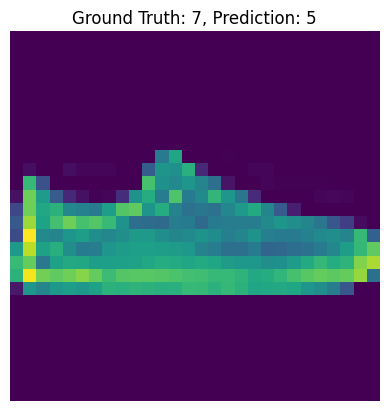

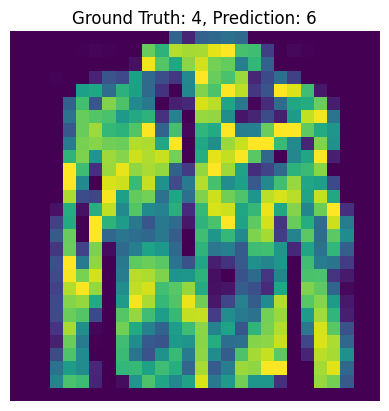

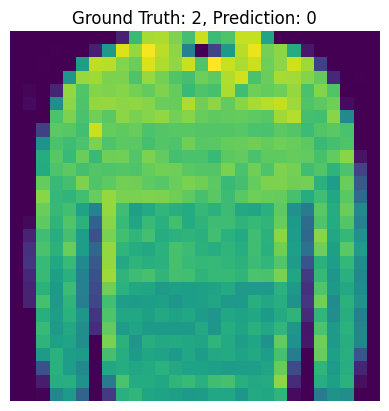

In [40]:
import matplotlib.pyplot as plt

def find_and_display_errors(modelNew2, dataloader, device):
    modelNew2.eval()  #set the model to evaluation mode
    errors_found = 0

    #iterate through the dataloader
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = modelNew2(inputs)
        _, predictions = torch.max(outputs, 1)  #predicted class

        #find errors
        mismatches = predictions != labels
        if mismatches.any():
            for i in range(len(inputs)):
                if mismatches[i]:
                    img = inputs[i] #display image, ground truth, and prediction
                    ground_truth = labels[i].item()
                    prediction = predictions[i].item()

                    #convert the image and display
                    image_np = img.permute(1, 2, 0).cpu().numpy()
                    plt.imshow(image_np)
                    plt.axis('off')
                    plt.title(f"Ground Truth: {ground_truth}, Prediction: {prediction}")
                    plt.show()

                    errors_found += 1
                    if errors_found >= 3:  #find 3 errors
                        return
#test on modelNew2
find_and_display_errors(modelNew2, test_dataloader, device)


Looking at these images, these are reasonable mistakes. For example, when I (a human) look the first image, I see that it is a shoe of some sort. The NN mistaked the sneaker for scandel. I think this is a reasonable error since I myself was not able to conclude what type of footwear the image is depicting. Simiraly, while viewing the following two images, I cannot even tell what either item is, therefore the errors are reasonable.